In [1]:
import torch
import plotly.express as px
from transformer_lens import HookedTransformer, utils, patching
from functools import partial
from transformers import AutoModelForCausalLM, AutoTokenizer

import numpy as np
from tqdm import tqdm

In [52]:
model_name = "/pscratch/sd/r/ritesh11/temp_dir/trained_models/unf_cot"
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True
)
tokenizer = AutoTokenizer.from_pretrained("Qwen3-1.7B")

model = HookedTransformer.from_pretrained_no_processing(
    model_name="Qwen/Qwen3-1.7B",
    hf_model=model,
    tokenizer=tokenizer,
    dtype=torch.bfloat16,
    trust_remote_code=True,
    device="cuda"
)
torch.set_grad_enabled(False)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model Qwen/Qwen3-1.7B into HookedTransformer


In [25]:
base_model = AutoModelForCausalLM.from_pretrained(
    "Qwen3-1.7B",
    trust_remote_code=True
)

base_model = HookedTransformer.from_pretrained_no_processing(
    model_name="Qwen/Qwen3-1.7B",
    hf_model=base_model,
    tokenizer=tokenizer,
    dtype=torch.bfloat16,
    trust_remote_code=True,
    device="cuda"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model Qwen/Qwen3-1.7B into HookedTransformer


In [3]:
NOISE_STD = 0.2
def corrupt_embedding_hook(embedding_hook_output, hook, subject_token_indices, seed):
    g = torch.Generator(device=embedding_hook_output.device).manual_seed(seed)
    noise_shape = embedding_hook_output[:, subject_token_indices, :].shape
    noise = torch.randn(
        noise_shape, generator=g, device=embedding_hook_output.device, dtype=embedding_hook_output.dtype
    ) * NOISE_STD
    embedding_hook_output[:, subject_token_indices, :] += noise
    return embedding_hook_output

In [4]:
def get_clean_and_corrupted_probs(model):
    
    # Get clean run
    _, clean_cache = model.run_with_cache(clean_tokens)
    clean_logits = model(clean_tokens)
    clean_prob = torch.softmax(clean_logits[0, -1], dim=-1)[correct_answer_token].item()

    # Get corrupted runs
    corrupted_probs = []
    for seed in range(NUM_SEEDS):
        hook_fn = partial(corrupt_embedding_hook,
                          subject_token_indices=subject_token_indices,
                          seed=seed)
        corrupted_logits = model.run_with_hooks(
            clean_tokens, fwd_hooks=[(utils.get_act_name("embed"), hook_fn)]
        )
        corrupted_probs.append(torch.softmax(corrupted_logits[0, -1], dim=-1)[correct_answer_token].item())

    corrupted_prob_mean = float(np.mean(corrupted_probs))

    model.reset_hooks(including_permanent=True)

    return clean_prob, corrupted_prob_mean, clean_cache

In [5]:
def causal_tracing_metric(patched_logits: torch.Tensor) -> torch.Tensor:

    # Get the probability of the correct token as a tensor
    patched_prob = torch.softmax(patched_logits[0, -1], dim=-1)[correct_answer_token]
    
    # These baselines are Python floats, convert them to tensors on the correct device
    clean_prob_tensor = torch.tensor(clean_prob, device=patched_prob.device)
    corrupted_prob_tensor = torch.tensor(corrupted_prob_mean, device=patched_prob.device)
    
    denominator = clean_prob_tensor - corrupted_prob_tensor
    if torch.abs(denominator) < 1e-6:
        return torch.tensor(0.0, device=patched_prob.device)
        
    # The final result is a zero-dimensional tensor
    return (patched_prob - corrupted_prob_tensor) / denominator

In [6]:
def run_avg_patching(model):
    patching_results_per_seed = []
    print(f"\nRunning causal tracing over {NUM_SEEDS} corruption seeds...")
    
    for seed in tqdm(range(NUM_SEEDS)):
        corrupt_hook = partial(corrupt_embedding_hook, subject_token_indices=subject_token_indices, seed=seed)
        model.add_hook(utils.get_act_name("embed"), corrupt_hook, is_permanent=True)
        
        patching_results_for_this_seed = patching.get_act_patch_resid_pre(
            model=model,
            corrupted_tokens=clean_tokens,
            clean_cache=clean_cache,
            patching_metric=causal_tracing_metric,
        )
        patching_results_per_seed.append(patching_results_for_this_seed)
        
        model.reset_hooks(including_permanent=True)

    return torch.stack(patching_results_per_seed).mean(dim=0)

In [7]:
def run_avg_patching_by_head(model):
    results_per_seed = []
    print(f"\nRunning causal tracing over {NUM_SEEDS} corruption seeds (by head)...")
    
    for seed in tqdm(range(NUM_SEEDS)):
        corrupt_hook = partial(corrupt_embedding_hook, subject_token_indices=subject_token_indices, seed=seed)
        model.add_hook(utils.get_act_name("embed"), corrupt_hook, is_permanent=True)
        
        # --- KEY CHANGE IS HERE ---
        patching_results_for_this_seed = patching.get_act_patch_attn_head_out_by_pos(
            model=model,
            corrupted_tokens=clean_tokens,
            clean_cache=clean_cache,
            patching_metric=causal_tracing_metric,
        )
        results_per_seed.append(patching_results_for_this_seed)
        
        model.reset_hooks(including_permanent=True)

    return torch.stack(results_per_seed).mean(dim=0)

In [8]:
def run_avg_patching_by_mlp(model):
    results_per_seed = []
    print(f"\nRunning causal tracing over {NUM_SEEDS} corruption seeds (by head)...")
    
    for seed in tqdm(range(NUM_SEEDS)):
        corrupt_hook = partial(corrupt_embedding_hook, subject_token_indices=subject_token_indices, seed=seed)
        model.add_hook(utils.get_act_name("embed"), corrupt_hook, is_permanent=True)
        
        # --- KEY CHANGE IS HERE ---
        patching_results_for_this_seed = patching.get_act_patch_mlp_out(
            model=model,
            corrupted_tokens=clean_tokens,
            clean_cache=clean_cache,
            patching_metric=causal_tracing_metric,
        )
        results_per_seed.append(patching_results_for_this_seed)
        
        model.reset_hooks(including_permanent=True)

    return torch.stack(results_per_seed).mean(dim=0)

In [148]:
def run_single_head_causal_trace(model, layer_idx, head_idx):
    seq_len = clean_tokens.shape[1]
    dest_positions = range(seq_len)
    source_positions = range(seq_len)

    # Correct column order: layer, head_index, dest_pos, src_pos
    index_df = pd.DataFrame(
        [(layer_idx, head_idx, d, s) for d in dest_positions for s in source_positions],
        columns=["layer", "head_index", "dest_pos", "src_pos"]
    )

    patching_results_per_seed = []
    for seed in tqdm(range(NUM_SEEDS)):
        corrupt_hook = partial(corrupt_embedding_hook,
                               subject_token_indices=subject_token_indices,
                               seed=seed)
        model.add_hook(utils.get_act_name("embed"), corrupt_hook, is_permanent=True)

        res = patching.get_act_patch_attn_head_pattern_dest_src_pos(
            model=model,
            corrupted_tokens=clean_tokens,  # <-- real corrupted tokens
            clean_cache=clean_cache,
            patching_metric=causal_tracing_metric,
            index_df=index_df,
            index_axis_names=None,
        )
        patching_results_per_seed.append(res)
        model.reset_hooks(including_permanent=True)

    averaged_results = torch.stack(patching_results_per_seed).mean(dim=0)
    return averaged_results.reshape(seq_len, seq_len)

In [133]:
NUM_SEEDS = 20

prompt = "<think>\nI recall the capital of Canada is Ottawa\n</think>\nCapital of Canada is "

clean_tokens = model.to_tokens(prompt)

# Robustly find the subject token indices
subject_string = " Ottawa Toronto Canada"
main_prompt_str_tokens = model.to_str_tokens(clean_tokens)
subject_str_tokens = model.to_str_tokens(subject_string)
subject_token_indices = [i for i, token in enumerate(main_prompt_str_tokens) if token in subject_str_tokens]

print(f"Prompt: '{prompt}'")
print(f"Tokenized: {main_prompt_str_tokens}")
print(f"Subject ('{subject_string}') is tokenized to {subject_str_tokens} at indices: {subject_token_indices}")

correct_answer = " Ottawa"
correct_answer_token = model.to_single_token(correct_answer)

clean_prob, corrupted_prob_mean, clean_cache = get_clean_and_corrupted_probs(model)

print(f"\nClean probability on '{correct_answer}': {clean_prob:.2%}")
print(f"Average corrupted probability on '{correct_answer}': {corrupted_prob_mean:.2%}")

Prompt: '<think>
I recall the capital of Canada is Ottawa
</think>
Capital of Canada is '
Tokenized: ['<think>', '\n', 'I', ' recall', ' the', ' capital', ' of', ' Canada', ' is', ' Ottawa', '\n', '</think>', '\n', 'Capital', ' of', ' Canada', ' is', ' ']
Subject (' Ottawa Toronto Canada') is tokenized to [' Ottawa', ' Toronto', ' Canada'] at indices: [7, 9, 15]

Clean probability on ' Ottawa': 69.92%
Average corrupted probability on ' Ottawa': 0.12%


In [131]:
utils.test_prompt(prompt, correct_answer, model)

Tokenized prompt: ['<think>', '\n', 'I', ' recall', ' the', ' capital', ' of', ' Canada', ' is', ' Ottawa', '\n', '</think>', '\n', 'Capital', ' of', ' Canada', ' is', ' ']
Tokenized answer: [' Ottawa']


Performance on answer token:
Rank: 0        Logit: 23.50 Prob: 69.92% Token: | Ottawa|

Top 0th token. Logit: 23.50 Prob: 69.92% Token: | Ottawa|
Top 1th token. Logit: 22.50 Prob: 25.78% Token: | Toronto|
Top 2th token. Logit: 18.38 Prob:  0.42% Token: |1|
Top 3th token. Logit: 18.38 Prob:  0.42% Token: | Vancouver|
Top 4th token. Logit: 18.00 Prob:  0.29% Token: |OTT|
Top 5th token. Logit: 17.62 Prob:  0.20% Token: | O|
Top 6th token. Logit: 17.50 Prob:  0.17% Token: | ott|
Top 7th token. Logit: 17.38 Prob:  0.15% Token: | OT|
Top 8th token. Logit: 17.38 Prob:  0.15% Token: | ت|
Top 9th token. Logit: 17.12 Prob:  0.12% Token: | Ontario|


Ranks of the answer tokens: [(' Ottawa', 0)]

In [75]:
patching_results_by_mlp = run_avg_patching(model)


Running causal tracing over 20 corruption seeds...


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:29<09:13, 29.14s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

 10%|█         | 2/20 [00:58<08:44, 29.12s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

 15%|█▌        | 3/20 [01:27<08:14, 29.10s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

 20%|██        | 4/20 [01:56<07:47, 29.20s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

 25%|██▌       | 5/20 [02:25<07:18, 29.23s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

 30%|███       | 6/20 [02:55<06:49, 29.24s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [03:24<06:19, 29.20s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

 40%|████      | 8/20 [03:53<05:50, 29.19s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [04:22<05:20, 29.18s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

 50%|█████     | 10/20 [04:51<04:51, 29.15s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [05:20<04:22, 29.13s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

 60%|██████    | 12/20 [05:49<03:52, 29.08s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [06:18<03:23, 29.05s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

 70%|███████   | 14/20 [06:47<02:53, 28.99s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [07:16<02:24, 28.93s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

 80%|████████  | 16/20 [07:45<01:55, 28.85s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [08:13<01:26, 28.82s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

 90%|█████████ | 18/20 [08:42<00:57, 28.84s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

 95%|█████████▌| 19/20 [09:11<00:28, 28.92s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

100%|██████████| 20/20 [09:40<00:00, 29.03s/it]


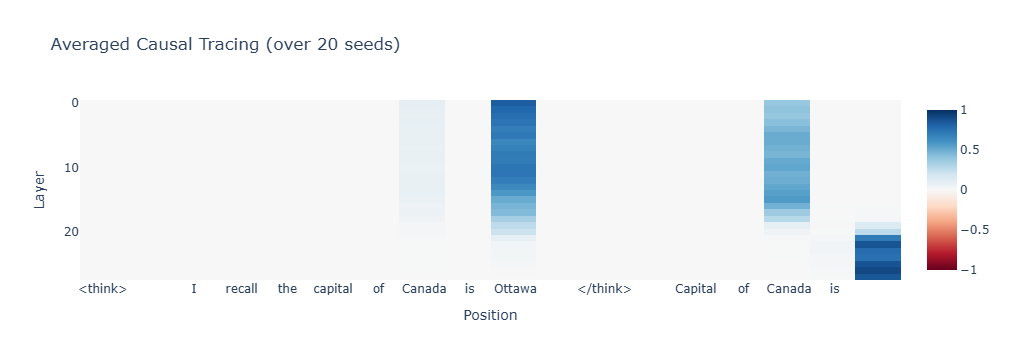

In [76]:
fig = px.imshow(
    utils.to_numpy(patching_results_by_mlp),
    title=f"Averaged Causal Tracing (over {NUM_SEEDS} seeds)",
    labels={"x": "Position", "y": "Layer"},
    color_continuous_scale="RdBu",
    color_continuous_midpoint=0.0,
    zmin=-1, zmax=1,
    aspect='auto'
)

fig.update_xaxes(
    tickmode='array',
    tickvals=list(range(len(main_prompt_str_tokens))),
    ticktext=main_prompt_str_tokens,
)


fig.show()

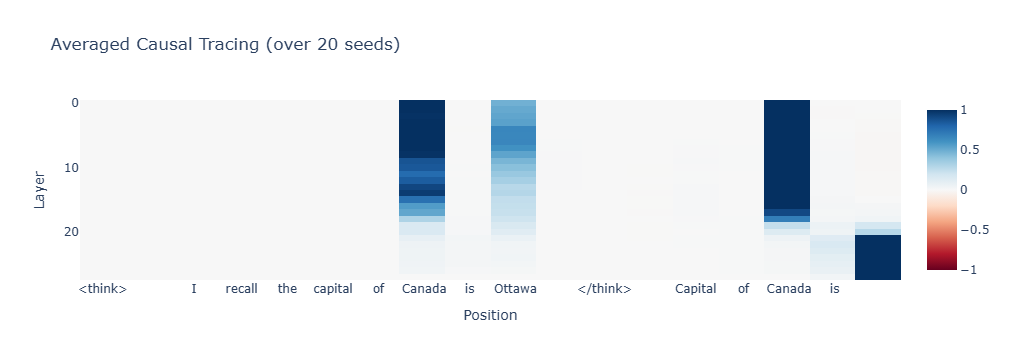

In [72]:
fig = px.imshow(
    utils.to_numpy(patching_results_by_mlp),
    title=f"Averaged Causal Tracing (over {NUM_SEEDS} seeds)",
    labels={"x": "Position", "y": "Layer"},
    color_continuous_scale="RdBu",
    color_continuous_midpoint=0.0,
    zmin=-1, zmax=1,
    aspect='auto'
)

fig.update_xaxes(
    tickmode='array',
    tickvals=list(range(len(main_prompt_str_tokens))),
    ticktext=main_prompt_str_tokens,
)


fig.show()

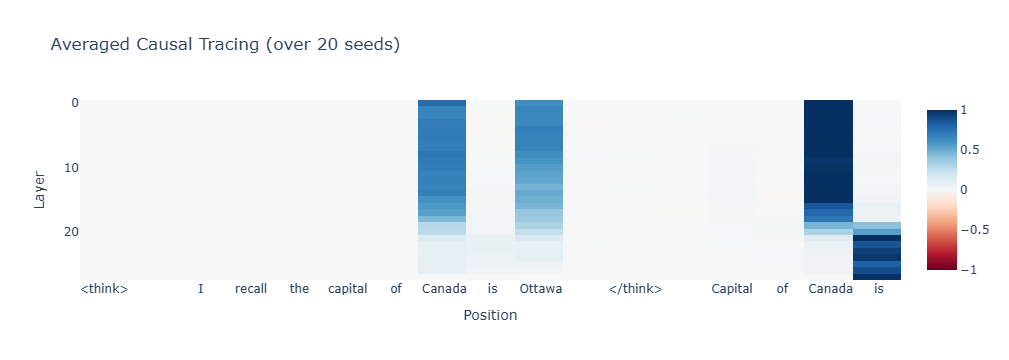

In [68]:
fig = px.imshow(
    utils.to_numpy(patching_results_by_mlp),
    title=f"Averaged Causal Tracing (over {NUM_SEEDS} seeds)",
    labels={"x": "Position", "y": "Layer"},
    color_continuous_scale="RdBu",
    color_continuous_midpoint=0.0,
    zmin=-1, zmax=1,
    aspect='auto'
)

fig.update_xaxes(
    tickmode='array',
    tickvals=list(range(len(main_prompt_str_tokens))),
    ticktext=main_prompt_str_tokens,
)


fig.show()

In [84]:
patching_results_by_mlp = run_avg_patching_by_mlp(model)


Running causal tracing over 20 corruption seeds (by head)...


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:27<08:33, 27.03s/it]

  0%|          | 0/476 [00:00<?, ?it/s]

 10%|█         | 2/20 [00:54<08:11, 27.29s/it]

  0%|          | 0/476 [00:00<?, ?it/s]

 15%|█▌        | 3/20 [01:22<07:48, 27.54s/it]

  0%|          | 0/476 [00:00<?, ?it/s]

 20%|██        | 4/20 [01:50<07:24, 27.77s/it]

  0%|          | 0/476 [00:00<?, ?it/s]

 25%|██▌       | 5/20 [02:18<06:56, 27.78s/it]

  0%|          | 0/476 [00:00<?, ?it/s]

 30%|███       | 6/20 [02:46<06:29, 27.80s/it]

  0%|          | 0/476 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [03:13<06:01, 27.79s/it]

  0%|          | 0/476 [00:00<?, ?it/s]

 40%|████      | 8/20 [03:41<05:33, 27.82s/it]

  0%|          | 0/476 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [04:09<05:05, 27.82s/it]

  0%|          | 0/476 [00:00<?, ?it/s]

 50%|█████     | 10/20 [04:37<04:38, 27.81s/it]

  0%|          | 0/476 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [05:05<04:10, 27.80s/it]

  0%|          | 0/476 [00:00<?, ?it/s]

 60%|██████    | 12/20 [05:32<03:42, 27.80s/it]

  0%|          | 0/476 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [06:00<03:14, 27.79s/it]

  0%|          | 0/476 [00:00<?, ?it/s]

 70%|███████   | 14/20 [06:28<02:45, 27.65s/it]

  0%|          | 0/476 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [06:55<02:17, 27.44s/it]

  0%|          | 0/476 [00:00<?, ?it/s]

 80%|████████  | 16/20 [07:21<01:49, 27.28s/it]

  0%|          | 0/476 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [07:48<01:21, 27.19s/it]

  0%|          | 0/476 [00:00<?, ?it/s]

 90%|█████████ | 18/20 [08:15<00:54, 27.13s/it]

  0%|          | 0/476 [00:00<?, ?it/s]

 95%|█████████▌| 19/20 [08:43<00:27, 27.15s/it]

  0%|          | 0/476 [00:00<?, ?it/s]

100%|██████████| 20/20 [09:10<00:00, 27.54s/it]


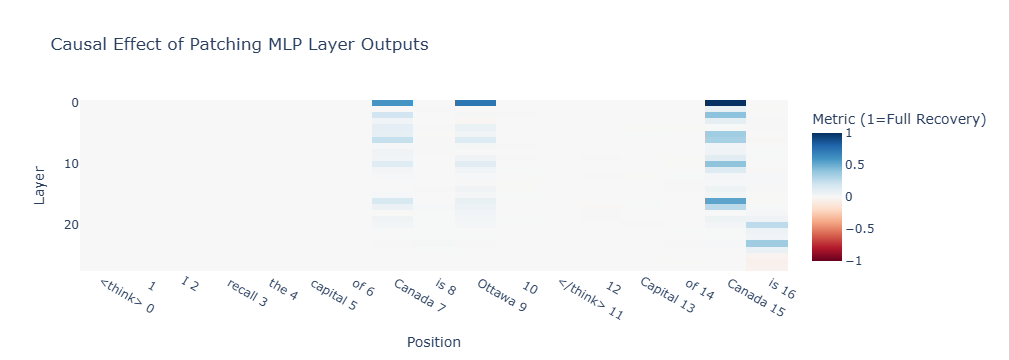

In [85]:
str_tokens = model.to_str_tokens(clean_tokens)
plot_labels = [f"{tok} {i}" for i, tok in enumerate(str_tokens)]

px.imshow(
    utils.to_numpy(patching_results_by_mlp.to(torch.float32)), # Cast for numpy/plotly
    title="Causal Effect of Patching MLP Layer Outputs",
    labels={"x": "Position", "y": "Layer", "color": "Metric (1=Full Recovery)"},
    x=plot_labels,
    color_continuous_scale="RdBu",
    color_continuous_midpoint=0.0,
    zmin=-1, zmax=1
).show()

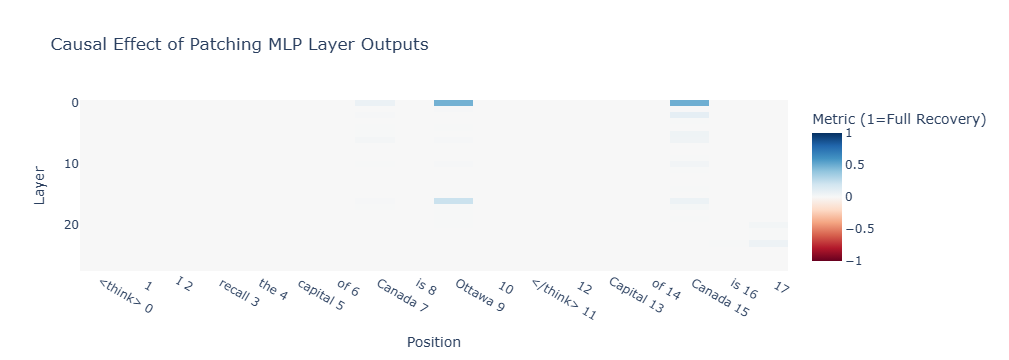

In [79]:
str_tokens = model.to_str_tokens(clean_tokens)
plot_labels = [f"{tok} {i}" for i, tok in enumerate(str_tokens)]

px.imshow(
    utils.to_numpy(patching_results_by_mlp.to(torch.float32)), # Cast for numpy/plotly
    title="Causal Effect of Patching MLP Layer Outputs",
    labels={"x": "Position", "y": "Layer", "color": "Metric (1=Full Recovery)"},
    x=plot_labels,
    color_continuous_scale="RdBu",
    color_continuous_midpoint=0.0,
    zmin=-1, zmax=1
).show()

In [86]:
from neel_plotly import line, imshow, scatter
import einops

In [93]:
NUM_SEEDS = 1

In [94]:
patching_results_by_head = run_avg_patching_by_head(model)


Running causal tracing over 1 corruption seeds (by head)...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8064 [00:00<?, ?it/s]

100%|██████████| 1/1 [07:46<00:00, 466.76s/it]


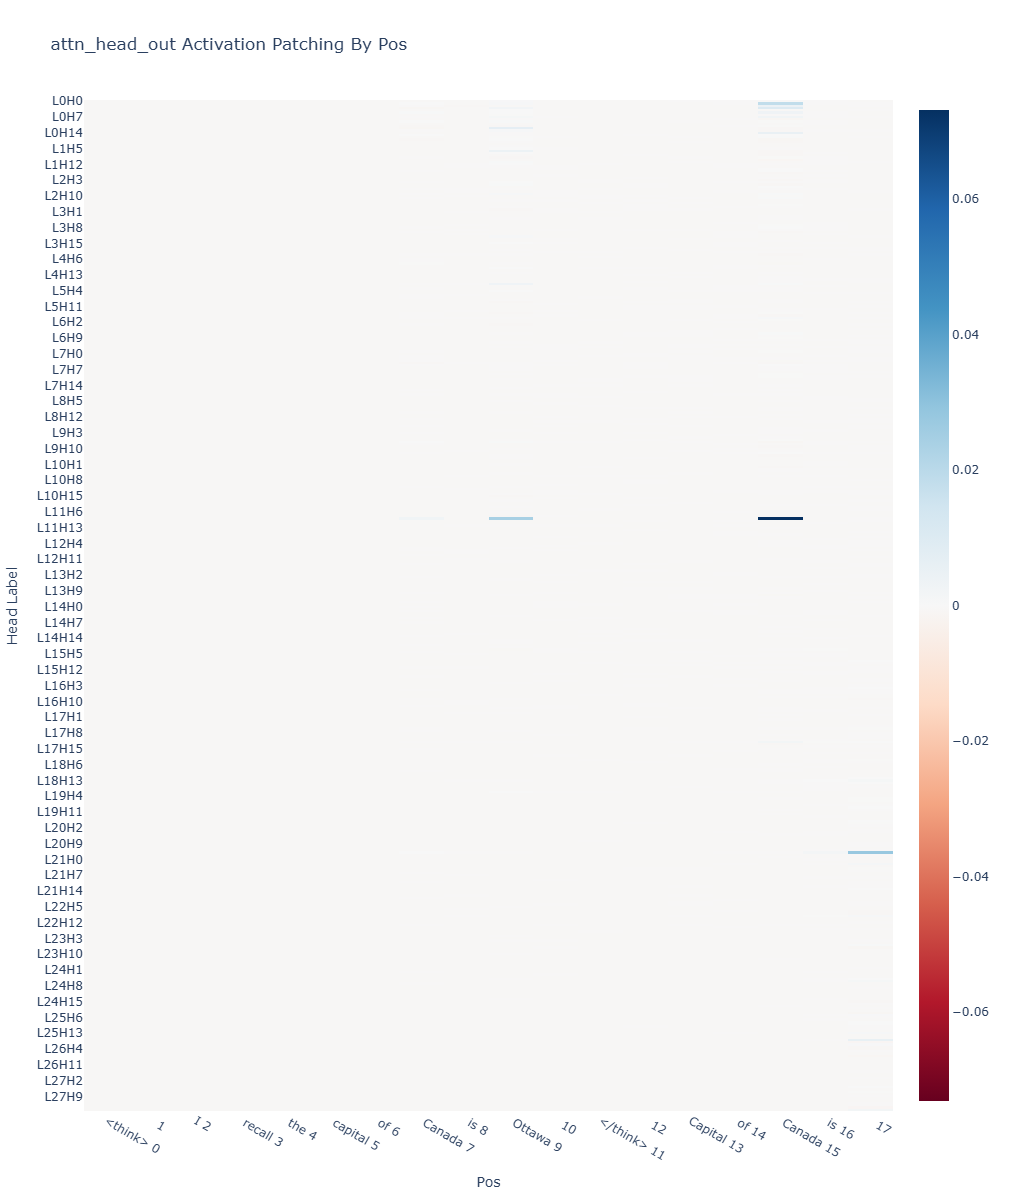

In [95]:
ALL_HEAD_LABELS = [f"L{i}H{j}" for i in range(model.cfg.n_layers) for j in range(model.cfg.n_heads)]
# Create a list of labels for the x-axis
str_tokens = model.to_str_tokens(clean_tokens)
x_labels = [f"{tok} {i}" for i, tok in enumerate(str_tokens)]
attn_head_out_act_patch_results = einops.rearrange(patching_results_by_head, "layer pos head -> (layer head) pos")
imshow(attn_head_out_act_patch_results, 
        yaxis="Head Label", 
        xaxis="Pos",
        height=1200,
        x=[f"{tok} {i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens))],
        y=ALL_HEAD_LABELS,
        title="attn_head_out Activation Patching By Pos")

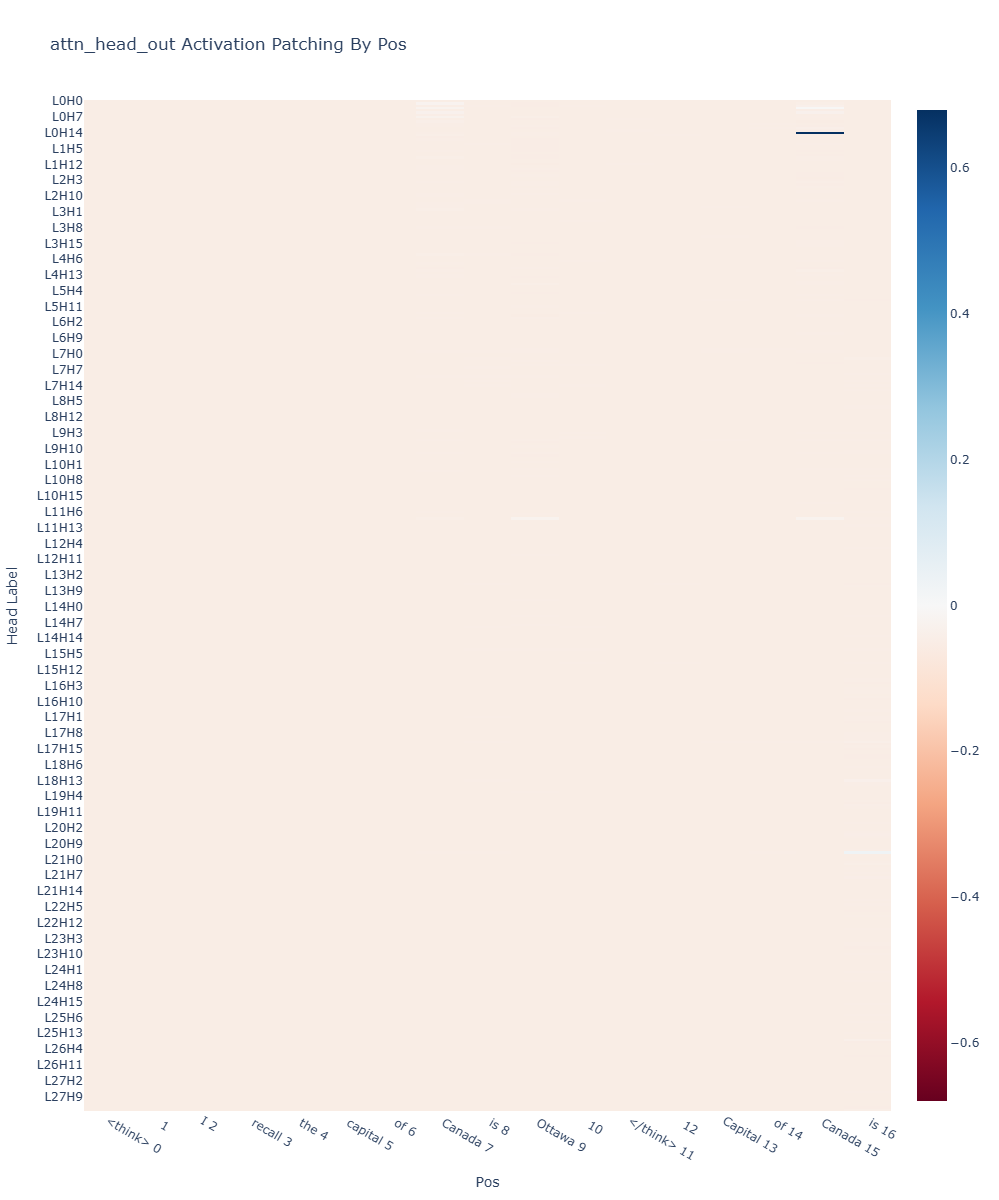

In [89]:
ALL_HEAD_LABELS = [f"L{i}H{j}" for i in range(model.cfg.n_layers) for j in range(model.cfg.n_heads)]
# Create a list of labels for the x-axis
str_tokens = model.to_str_tokens(clean_tokens)
x_labels = [f"{tok} {i}" for i, tok in enumerate(str_tokens)]
attn_head_out_act_patch_results = einops.rearrange(patching_results_by_head, "layer pos head -> (layer head) pos")
imshow(attn_head_out_act_patch_results, 
        yaxis="Head Label", 
        xaxis="Pos",
        height=1200,
        x=[f"{tok} {i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens))],
        y=ALL_HEAD_LABELS,
        title="attn_head_out Activation Patching By Pos")

In [169]:
from typing import Union, List, Optional
from transformer_lens import ActivationCache

In [184]:
def patch_head_vector(
    corrupted_head_vector: Float[torch.Tensor, "batch pos head_index d_head"],
    hook,
    head_index,
    clean_cache,
):
    corrupted_head_vector[:, :, head_index, :] = clean_cache[hook.name][
        :, :, head_index, :
    ]
    return corrupted_head_vector


patched_head_z_diff = torch.zeros(
    model.cfg.n_layers, model.cfg.n_heads, device='cuda', dtype=torch.float32
)

hook_fn = partial(corrupt_embedding_hook,
                          subject_token_indices=subject_token_indices,
                          seed=22)
for layer in range(9):
    for head_index in range(model.cfg.n_heads):
        
        attn_hook_fn = partial(patch_head_vector, head_index=head_index, clean_cache=clean_cache)
        patched_logits = model.run_with_hooks(
            clean_tokens,
            fwd_hooks=[(utils.get_act_name("embed"), hook_fn), (utils.get_act_name("z", layer, "attn"), attn_hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = causal_tracing_metric(patched_logits)

        patched_head_z_diff[layer, head_index] = patched_logit_diff

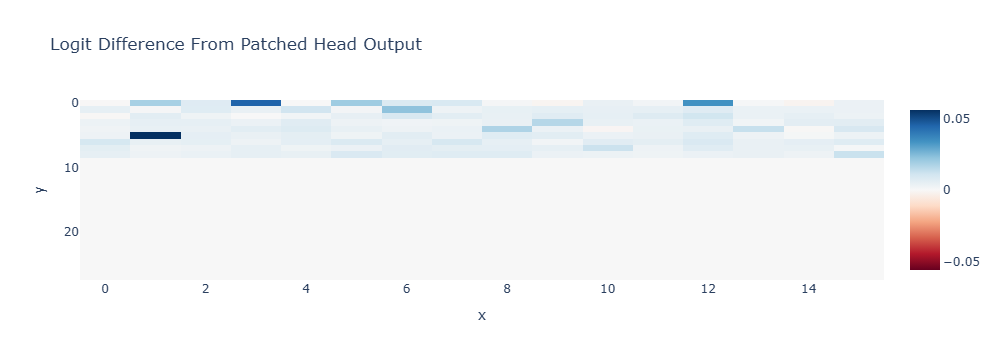

In [186]:
imshow(
    patched_head_z_diff,
    title="Logit Difference From Patched Head Output",
    labels={"x": "Head", "y": "Layer"},
)

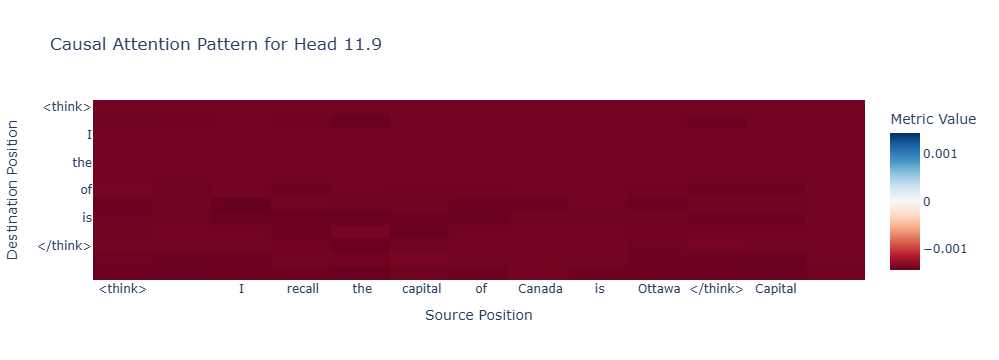

In [158]:
tokens = model.to_str_tokens(clean_tokens[0])  # flatten to sequence tokens

px.imshow(
    causal_attention_pattern.detach().cpu().numpy(),
    title=f"Causal Attention Pattern for Head {layer_to_analyze}.{head_to_analyze}",
    labels={"x": "Source Position", "y": "Destination Position", "color": "Metric Value"},
    x=tokens,  # len == seq_len
    y=tokens,  # len == seq_len
    color_continuous_scale="RdBu",
    color_continuous_midpoint=0.0,
    aspect='auto'
).update_yaxes(
    autorange="reversed"
).show()

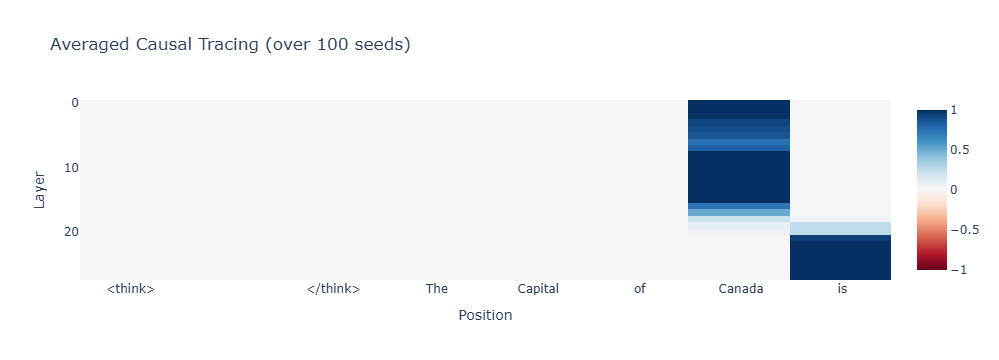

In [155]:
px.imshow(
    utils.to_numpy(patching_results_avg),
    title=f"Averaged Causal Tracing (over {NUM_SEEDS} seeds)",
    labels={"x": "Position", "y": "Layer"},
    x=model.to_str_tokens(clean_tokens),
    color_continuous_scale="RdBu",
    color_continuous_midpoint=0.0,
    zmin=-1, zmax=1
).show()

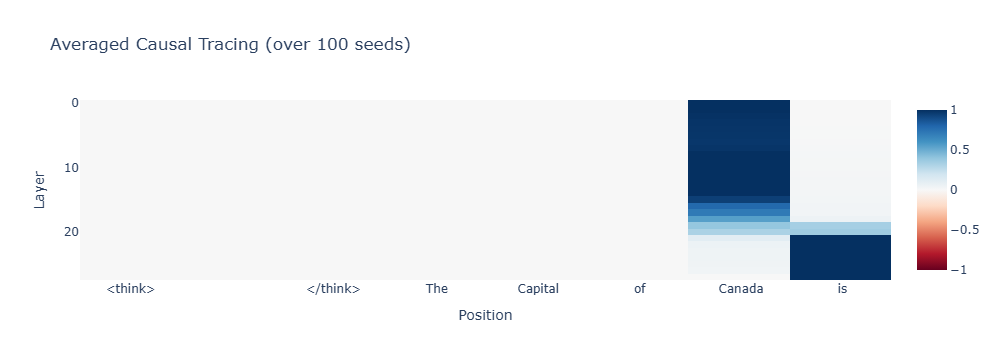

In [159]:
px.imshow(
    utils.to_numpy(patching_results_avg),
    title=f"Averaged Causal Tracing (over {NUM_SEEDS} seeds)",
    labels={"x": "Position", "y": "Layer"},
    x=model.to_str_tokens(clean_tokens),
    color_continuous_scale="RdBu",
    color_continuous_midpoint=0.0,
    zmin=-1, zmax=1
).show()